## Imports and Seed Setting

In [1]:
# imports
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import joblib
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.7.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Hyperparams of the competition


In [3]:
c_telescope = 1152
sbm_telescope = int(1152*0.75)  #864

## Import and Preprocess the data

In [4]:
dataset = pd.read_csv('Training.csv')

In [5]:
# split into test and training datasets
test_size = int(dataset.shape[0]//10) # size of the test set is 10% of the training

X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

In [6]:
#normalize the data

# choice of scaler
scaler = MinMaxScaler()

# fitting the scaler
scaler.fit(X_train_raw)

#transform X_train_raw and X_test_raw
X_pp_train = scaler.transform(X_train_raw)
X_pp_test = scaler.transform(X_test_raw)

# scaler returns numpy arrays (type = ndarray). Reconvert to dataframe for better plotting
data = np.concatenate((X_pp_train,X_pp_test))
data = pd.DataFrame(data, columns = dataset.columns)
X_pp_train = data.iloc[:-test_size]
X_pp_test = data.iloc[-test_size:]

In [7]:
# save the scaler
scaler_dir = 'vars/scalers'
if not os.path.exists(scaler_dir):
    os.makedirs(scaler_dir)

scaler_path = os.path.join(scaler_dir, 'min_max_scaler.gz')
joblib.dump(scaler, scaler_path)

['vars/scalers\\min_max_scaler.gz']

## Create Sequences

In [72]:
# First objective should be to predict the next quarter of test length. You can look at the instructions for the competition for 
# more information. So the total length to predict is c_telescope = 1152. In the first part of the competition we must predict 3 
# quarters of the total test sequences, i.e. 3/4 * 1152 = 864. One single quarter is made up of 1152/4 = 288. I believe, whatever
# the final structure of the model, that we could firs predict a quarter and then recgressively predict the rest.

quarter_tel = (1152//4) #288

# We can try to predict the quarter in 4 steps of 36

reg = 4
telescope = int(quarter_tel//4) #72
assert quarter_tel%4 == 0

# target labels are all the labels
target_labels = dataset.columns

# Hyper parameters for how to build the sequences. The total length of the dataset is 68528, so quite large. I would take the
# usual length to start with. We will obtain a very large number of sequences. Note that in 
# the inspection of the data the beginning of the sequence seemed quite different from the later evolution. One could consider removing 
# the first part as a possibility. 

window = 10
stride = 2

In [73]:
# build sequence function
def build_sequences(df, target_labels=['pollution'], window=200, stride = 20):
    # check to avoid errrors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values #copy() makes a deep copy
    temp_labels = df[target_labels].copy().values
    need_4_padding = len(df)%window != 0
    
    if(need_4_padding):
        padding_len = window-len(df)%window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding, df))
        padding = np.zeros((padding_len, temp_labels.shape[1]), dtype='float64')
        temp_labels = np.concatenate((padding, temp_labels))
        assert len(temp_df)%window == 0
        
    for idx in np.arange(0, len(temp_df)-window, stride):
        dataset.append(temp_df[idx:idx+window])
    dataset = np.array(dataset)
    return dataset

In [74]:
X_train = build_sequences(
    X_pp_train,
    target_labels=target_labels,
    window=window,
    stride=stride,
    )
X_test = build_sequences(
    X_pp_test,
    target_labels=target_labels,
    window=window,
    stride=stride,
    )

In [75]:
# Inspect random sequence

# plotting function 
def inspect_multivariate(X, columns, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
        # print(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+1))
    plt.show()    

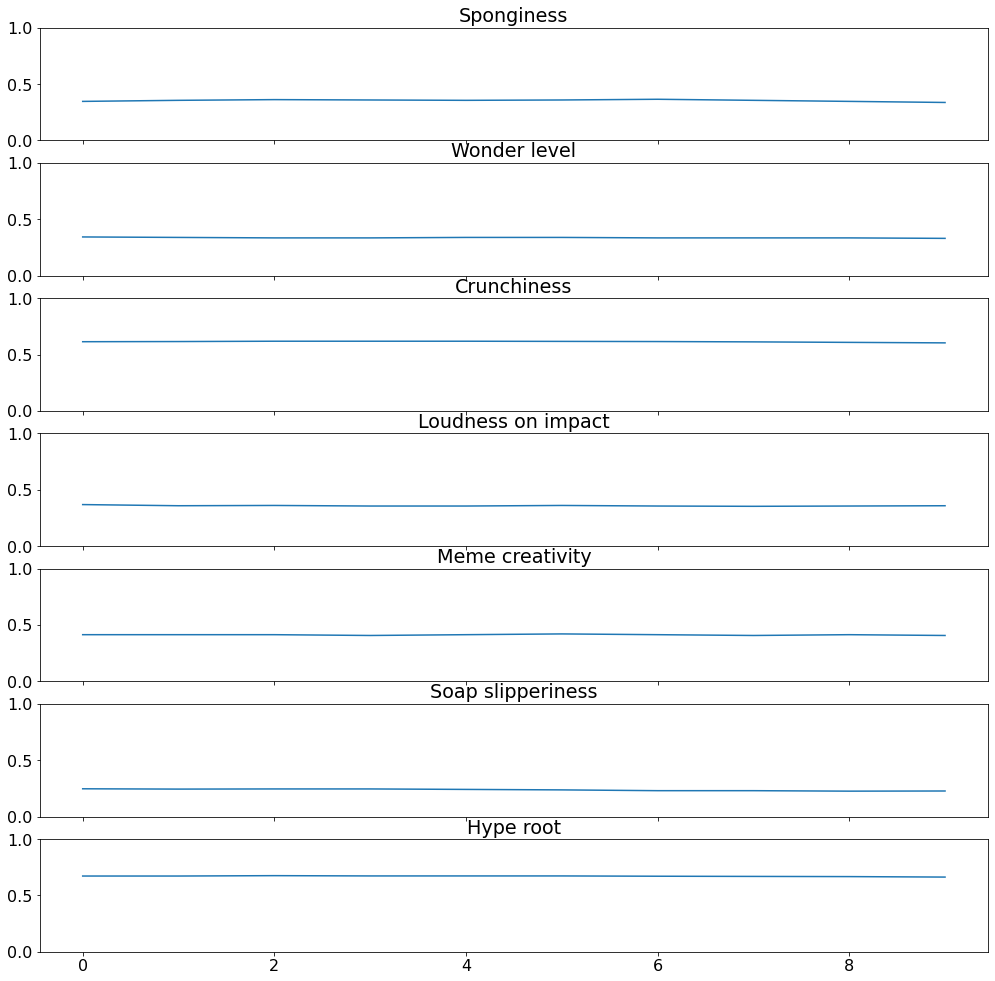

In [76]:
# inspect training sequence
inspect_multivariate(X_train, target_labels)

## Autoencoder Model

In [77]:
n_features = target_labels.size
input_shape = (window, n_features)

In [78]:
n_features

7

In [116]:
from tensorflow.keras.layers import LSTM, Dense

def build_autoencoder(window, n_features):
    input_shape=(window, n_features)
    encoder = tfk.models.Sequential([
        LSTM(32, return_sequences = True),
        LSTM(16, return_sequences=False)
    ],
        name ='Encoder'
    )
    
    latent_representation = tfkl.RepeatVector(window, name='latent_representation')
    
    decoder = tfk.models.Sequential([
        LSTM(16, return_sequences=True, name='decoder_1'),
        LSTM(32, return_sequences=True, name='decoder_2'),
        tfkl.TimeDistributed(Dense(n_features))
    ], name='decoder')
    
    autoencoder_input = tfkl.Input(shape=(input_shape), name='encoder_input')
    z = encoder(autoencoder_input)
    z = latent_representation(z)
    autoencoder = tfk.Model(inputs=autoencoder_input, outputs=decoder(z), name ='Autoencoder')
    return encoder, decoder, autoencoder

In [117]:
X_train = build_sequences(
    X_pp_train,
    target_labels=target_labels,
    window=window,
    stride=stride,
    )
X_test = build_sequences(
    X_pp_test,
    target_labels=target_labels,
    window=window,
    stride=stride,
    )

In [118]:
enc, dec, ae = build_autoencoder(window, n_features)

In [119]:
ae.summary(expand_nested=True)

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 10, 7)]           0         
                                                                 
 Encoder (Sequential)        (None, 16)                8256      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| lstm_34 (LSTM)            (None, 10, 32)            5120      |
|                                                               |
| lstm_35 (LSTM)            (None, 16)                3136      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 latent_representation (Repe  (None, 10, 16)           0         
 atVector)                                                       
                                                                 
 decoder (Sequential)        (None, 10, 7)             8615      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [120]:
# compile the autoencoder
ae.compile(
    optimizer = tf.optimizers.Adam(learning_rate=1e-3),
    loss='mse', # because we have two populations...
    metrics = ['mse', 'mae']
)

In [121]:
history=ae.fit(
    X_train,
    X_train, #obviously because it is an autoencoder
    batch_size = 256,
    epochs=1000,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
    ]
).history

Epoch 1/1000
109/109 [==============================] - 6s 16ms/step - loss: 0.0757 - mse: 0.0757 - mae: 0.2079 - val_loss: 0.0270 - val_mse: 0.0270 - val_mae: 0.1232 - lr: 0.0010
Epoch 2/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1098 - val_loss: 0.0163 - val_mse: 0.0163 - val_mae: 0.0992 - lr: 0.0010
Epoch 3/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0899 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0842 - lr: 0.0010
Epoch 4/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0667 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0565 - lr: 0.0010
Epoch 5/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0493 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0454 - lr: 0.0010
Epoch 6/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0034 - mse: 0.0034 - mae: 

Epoch 46/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0212 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0239 - lr: 3.1250e-05
Epoch 47/1000
109/109 [==============================] - 1s 9ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0212 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0239 - lr: 1.5625e-05
Epoch 48/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0212 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0239 - lr: 1.5625e-05
Epoch 49/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0212 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0239 - lr: 1.5625e-05
Epoch 50/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0212 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0239 - lr: 1.5625e-05
Epoch 51/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0

109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0211 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0238 - lr: 1.0000e-05
Epoch 91/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0211 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0238 - lr: 1.0000e-05
Epoch 92/1000
109/109 [==============================] - 1s 9ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0211 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0238 - lr: 1.0000e-05
Epoch 93/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0210 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0238 - lr: 1.0000e-05
Epoch 94/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0210 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0238 - lr: 1.0000e-05
Epoch 95/1000
109/109 [==============================] - 1s 9ms/step - loss: 0.0011 - mse: 0.0

109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0209 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0237 - lr: 1.0000e-05
Epoch 135/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0209 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0237 - lr: 1.0000e-05
Epoch 136/1000
109/109 [==============================] - 1s 9ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0209 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0237 - lr: 1.0000e-05
Epoch 137/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0209 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0237 - lr: 1.0000e-05
Epoch 138/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0209 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0237 - lr: 1.0000e-05
Epoch 139/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0010 - mse

109/109 [==============================] - 1s 8ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0208 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0235 - lr: 1.0000e-05
Epoch 179/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0208 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0235 - lr: 1.0000e-05
Epoch 180/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0208 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0235 - lr: 1.0000e-05
Epoch 181/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0208 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0235 - lr: 1.0000e-05
Epoch 182/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0208 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0235 - lr: 1.0000e-05
Epoch 183/1000
109/109 [==============================] - 1s 8ms/step - loss: 0.0010 - mse

109/109 [==============================] - 1s 8ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0206 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0232 - lr: 1.0000e-05
Epoch 223/1000
109/109 [==============================] - 1s 8ms/step - loss: 9.9891e-04 - mse: 9.9891e-04 - mae: 0.0206 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0231 - lr: 1.0000e-05
Epoch 224/1000
109/109 [==============================] - 1s 8ms/step - loss: 9.9752e-04 - mse: 9.9752e-04 - mae: 0.0206 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0231 - lr: 1.0000e-05
Epoch 225/1000
109/109 [==============================] - 1s 8ms/step - loss: 9.9613e-04 - mse: 9.9613e-04 - mae: 0.0206 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0231 - lr: 1.0000e-05
Epoch 226/1000
109/109 [==============================] - 1s 8ms/step - loss: 9.9469e-04 - mse: 9.9469e-04 - mae: 0.0206 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0230 - lr: 1.0000e-05
Epoch 227/1000
109/109 [==============================] - 

109/109 [==============================] - 1s 9ms/step - loss: 9.1303e-04 - mse: 9.1303e-04 - mae: 0.0199 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0219 - lr: 1.0000e-05
Epoch 265/1000
109/109 [==============================] - 1s 9ms/step - loss: 9.1021e-04 - mse: 9.1021e-04 - mae: 0.0199 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0219 - lr: 1.0000e-05
Epoch 266/1000
109/109 [==============================] - 1s 9ms/step - loss: 9.0766e-04 - mse: 9.0766e-04 - mae: 0.0199 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0218 - lr: 1.0000e-05
Epoch 267/1000
109/109 [==============================] - 1s 9ms/step - loss: 9.0503e-04 - mse: 9.0503e-04 - mae: 0.0199 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0218 - lr: 1.0000e-05
Epoch 268/1000
109/109 [==============================] - 1s 9ms/step - loss: 9.0248e-04 - mse: 9.0248e-04 - mae: 0.0198 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0217 - lr: 1.0000e-05
Epoch 269/1000
109/109 [==========================

109/109 [==============================] - 1s 8ms/step - loss: 8.2120e-04 - mse: 8.2120e-04 - mae: 0.0190 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0202 - lr: 1.0000e-05
Epoch 307/1000
109/109 [==============================] - 1s 8ms/step - loss: 8.1965e-04 - mse: 8.1965e-04 - mae: 0.0190 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0202 - lr: 1.0000e-05
Epoch 308/1000
109/109 [==============================] - 1s 8ms/step - loss: 8.1821e-04 - mse: 8.1821e-04 - mae: 0.0189 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0202 - lr: 1.0000e-05
Epoch 309/1000
109/109 [==============================] - 1s 8ms/step - loss: 8.1676e-04 - mse: 8.1676e-04 - mae: 0.0189 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0201 - lr: 1.0000e-05
Epoch 310/1000
109/109 [==============================] - 1s 8ms/step - loss: 8.1536e-04 - mse: 8.1536e-04 - mae: 0.0189 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0201 - lr: 1.0000e-05
Epoch 311/1000
109/109 [==========================

109/109 [==============================] - 1s 8ms/step - loss: 7.8165e-04 - mse: 7.8165e-04 - mae: 0.0185 - val_loss: 9.4634e-04 - val_mse: 9.4634e-04 - val_mae: 0.0194 - lr: 1.0000e-05
Epoch 348/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.8103e-04 - mse: 7.8103e-04 - mae: 0.0185 - val_loss: 9.4339e-04 - val_mse: 9.4339e-04 - val_mae: 0.0193 - lr: 1.0000e-05
Epoch 349/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.8041e-04 - mse: 7.8041e-04 - mae: 0.0185 - val_loss: 9.4304e-04 - val_mse: 9.4304e-04 - val_mae: 0.0193 - lr: 1.0000e-05
Epoch 350/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.7981e-04 - mse: 7.7981e-04 - mae: 0.0185 - val_loss: 9.4165e-04 - val_mse: 9.4165e-04 - val_mae: 0.0193 - lr: 1.0000e-05
Epoch 351/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.7940e-04 - mse: 7.7940e-04 - mae: 0.0185 - val_loss: 9.4071e-04 - val_mse: 9.4071e-04 - val_mae: 0.0193 - lr: 1.0000e-05
Epoch 352/

Epoch 388/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.6372e-04 - mse: 7.6372e-04 - mae: 0.0183 - val_loss: 9.0852e-04 - val_mse: 9.0852e-04 - val_mae: 0.0189 - lr: 1.0000e-05
Epoch 389/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.6337e-04 - mse: 7.6337e-04 - mae: 0.0183 - val_loss: 9.0813e-04 - val_mse: 9.0813e-04 - val_mae: 0.0189 - lr: 1.0000e-05
Epoch 390/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.6300e-04 - mse: 7.6300e-04 - mae: 0.0183 - val_loss: 9.0718e-04 - val_mse: 9.0718e-04 - val_mae: 0.0189 - lr: 1.0000e-05
Epoch 391/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.6266e-04 - mse: 7.6266e-04 - mae: 0.0182 - val_loss: 9.0619e-04 - val_mse: 9.0619e-04 - val_mae: 0.0188 - lr: 1.0000e-05
Epoch 392/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.6242e-04 - mse: 7.6242e-04 - mae: 0.0182 - val_loss: 9.0604e-04 - val_mse: 9.0604e-04 - val_mae: 0.0188 - lr: 1.0000

Epoch 429/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.5263e-04 - mse: 7.5263e-04 - mae: 0.0181 - val_loss: 8.8758e-04 - val_mse: 8.8758e-04 - val_mae: 0.0186 - lr: 1.0000e-05
Epoch 430/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.5237e-04 - mse: 7.5237e-04 - mae: 0.0181 - val_loss: 8.8627e-04 - val_mse: 8.8627e-04 - val_mae: 0.0186 - lr: 1.0000e-05
Epoch 431/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.5218e-04 - mse: 7.5218e-04 - mae: 0.0181 - val_loss: 8.8606e-04 - val_mse: 8.8606e-04 - val_mae: 0.0186 - lr: 1.0000e-05
Epoch 432/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.5199e-04 - mse: 7.5199e-04 - mae: 0.0181 - val_loss: 8.8534e-04 - val_mse: 8.8534e-04 - val_mae: 0.0186 - lr: 1.0000e-05
Epoch 433/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.5176e-04 - mse: 7.5176e-04 - mae: 0.0181 - val_loss: 8.8522e-04 - val_mse: 8.8522e-04 - val_mae: 0.0186 - lr: 1.0000

Epoch 470/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.4473e-04 - mse: 7.4473e-04 - mae: 0.0180 - val_loss: 8.7155e-04 - val_mse: 8.7155e-04 - val_mae: 0.0184 - lr: 1.0000e-05
Epoch 471/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.4457e-04 - mse: 7.4457e-04 - mae: 0.0180 - val_loss: 8.7167e-04 - val_mse: 8.7167e-04 - val_mae: 0.0184 - lr: 1.0000e-05
Epoch 472/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.4450e-04 - mse: 7.4450e-04 - mae: 0.0180 - val_loss: 8.7202e-04 - val_mse: 8.7202e-04 - val_mae: 0.0184 - lr: 1.0000e-05
Epoch 473/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.4425e-04 - mse: 7.4425e-04 - mae: 0.0180 - val_loss: 8.7093e-04 - val_mse: 8.7093e-04 - val_mae: 0.0184 - lr: 1.0000e-05
Epoch 474/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.4405e-04 - mse: 7.4405e-04 - mae: 0.0180 - val_loss: 8.7098e-04 - val_mse: 8.7098e-04 - val_mae: 0.0184 - lr: 1.0000

Epoch 511/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.3854e-04 - mse: 7.3854e-04 - mae: 0.0179 - val_loss: 8.6058e-04 - val_mse: 8.6058e-04 - val_mae: 0.0183 - lr: 1.0000e-05
Epoch 512/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.3851e-04 - mse: 7.3851e-04 - mae: 0.0179 - val_loss: 8.5979e-04 - val_mse: 8.5979e-04 - val_mae: 0.0182 - lr: 1.0000e-05
Epoch 513/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.3828e-04 - mse: 7.3828e-04 - mae: 0.0179 - val_loss: 8.6009e-04 - val_mse: 8.6009e-04 - val_mae: 0.0182 - lr: 1.0000e-05
Epoch 514/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.3817e-04 - mse: 7.3817e-04 - mae: 0.0179 - val_loss: 8.5972e-04 - val_mse: 8.5972e-04 - val_mae: 0.0182 - lr: 1.0000e-05
Epoch 515/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.3800e-04 - mse: 7.3800e-04 - mae: 0.0179 - val_loss: 8.5929e-04 - val_mse: 8.5929e-04 - val_mae: 0.0182 - lr: 1.0000

Epoch 552/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.3326e-04 - mse: 7.3326e-04 - mae: 0.0178 - val_loss: 8.5106e-04 - val_mse: 8.5106e-04 - val_mae: 0.0181 - lr: 1.0000e-05
Epoch 553/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.3313e-04 - mse: 7.3313e-04 - mae: 0.0178 - val_loss: 8.5011e-04 - val_mse: 8.5011e-04 - val_mae: 0.0181 - lr: 1.0000e-05
Epoch 554/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.3303e-04 - mse: 7.3303e-04 - mae: 0.0178 - val_loss: 8.4991e-04 - val_mse: 8.4991e-04 - val_mae: 0.0181 - lr: 1.0000e-05
Epoch 555/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.3287e-04 - mse: 7.3287e-04 - mae: 0.0178 - val_loss: 8.5017e-04 - val_mse: 8.5017e-04 - val_mae: 0.0181 - lr: 1.0000e-05
Epoch 556/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.3286e-04 - mse: 7.3286e-04 - mae: 0.0178 - val_loss: 8.5014e-04 - val_mse: 8.5014e-04 - val_mae: 0.0181 - lr: 1.0000

Epoch 593/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.2848e-04 - mse: 7.2848e-04 - mae: 0.0178 - val_loss: 8.4259e-04 - val_mse: 8.4259e-04 - val_mae: 0.0180 - lr: 1.0000e-05
Epoch 594/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.2838e-04 - mse: 7.2838e-04 - mae: 0.0178 - val_loss: 8.4266e-04 - val_mse: 8.4266e-04 - val_mae: 0.0180 - lr: 1.0000e-05
Epoch 595/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.2823e-04 - mse: 7.2823e-04 - mae: 0.0178 - val_loss: 8.4238e-04 - val_mse: 8.4238e-04 - val_mae: 0.0180 - lr: 1.0000e-05
Epoch 596/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.2813e-04 - mse: 7.2813e-04 - mae: 0.0178 - val_loss: 8.4177e-04 - val_mse: 8.4177e-04 - val_mae: 0.0180 - lr: 1.0000e-05
Epoch 597/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.2805e-04 - mse: 7.2805e-04 - mae: 0.0178 - val_loss: 8.4207e-04 - val_mse: 8.4207e-04 - val_mae: 0.0180 - lr: 1.0000

Epoch 634/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.2389e-04 - mse: 7.2389e-04 - mae: 0.0177 - val_loss: 8.3471e-04 - val_mse: 8.3471e-04 - val_mae: 0.0179 - lr: 1.0000e-05
Epoch 635/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.2384e-04 - mse: 7.2384e-04 - mae: 0.0177 - val_loss: 8.3478e-04 - val_mse: 8.3478e-04 - val_mae: 0.0179 - lr: 1.0000e-05
Epoch 636/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.2371e-04 - mse: 7.2371e-04 - mae: 0.0177 - val_loss: 8.3533e-04 - val_mse: 8.3533e-04 - val_mae: 0.0179 - lr: 1.0000e-05
Epoch 637/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.2362e-04 - mse: 7.2362e-04 - mae: 0.0177 - val_loss: 8.3433e-04 - val_mse: 8.3433e-04 - val_mae: 0.0179 - lr: 1.0000e-05
Epoch 638/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.2346e-04 - mse: 7.2346e-04 - mae: 0.0177 - val_loss: 8.3450e-04 - val_mse: 8.3450e-04 - val_mae: 0.0179 - lr: 1.0000

Epoch 675/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.1944e-04 - mse: 7.1944e-04 - mae: 0.0177 - val_loss: 8.2753e-04 - val_mse: 8.2753e-04 - val_mae: 0.0178 - lr: 1.0000e-05
Epoch 676/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.1936e-04 - mse: 7.1936e-04 - mae: 0.0177 - val_loss: 8.2757e-04 - val_mse: 8.2757e-04 - val_mae: 0.0178 - lr: 1.0000e-05
Epoch 677/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.1926e-04 - mse: 7.1926e-04 - mae: 0.0177 - val_loss: 8.2781e-04 - val_mse: 8.2781e-04 - val_mae: 0.0178 - lr: 1.0000e-05
Epoch 678/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.1913e-04 - mse: 7.1913e-04 - mae: 0.0177 - val_loss: 8.2772e-04 - val_mse: 8.2772e-04 - val_mae: 0.0178 - lr: 1.0000e-05
Epoch 679/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.1910e-04 - mse: 7.1910e-04 - mae: 0.0177 - val_loss: 8.2737e-04 - val_mse: 8.2737e-04 - val_mae: 0.0178 - lr: 1.0000

Epoch 716/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1511e-04 - mse: 7.1511e-04 - mae: 0.0176 - val_loss: 8.2229e-04 - val_mse: 8.2229e-04 - val_mae: 0.0178 - lr: 1.0000e-05
Epoch 717/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1498e-04 - mse: 7.1498e-04 - mae: 0.0176 - val_loss: 8.2142e-04 - val_mse: 8.2142e-04 - val_mae: 0.0178 - lr: 1.0000e-05
Epoch 718/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1489e-04 - mse: 7.1489e-04 - mae: 0.0176 - val_loss: 8.2108e-04 - val_mse: 8.2108e-04 - val_mae: 0.0177 - lr: 1.0000e-05
Epoch 719/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1481e-04 - mse: 7.1481e-04 - mae: 0.0176 - val_loss: 8.2091e-04 - val_mse: 8.2091e-04 - val_mae: 0.0177 - lr: 1.0000e-05
Epoch 720/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1465e-04 - mse: 7.1465e-04 - mae: 0.0176 - val_loss: 8.2023e-04 - val_mse: 8.2023e-04 - val_mae: 0.0177 - lr: 1.0000

Epoch 757/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1083e-04 - mse: 7.1083e-04 - mae: 0.0176 - val_loss: 8.1560e-04 - val_mse: 8.1560e-04 - val_mae: 0.0177 - lr: 1.0000e-05
Epoch 758/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1078e-04 - mse: 7.1078e-04 - mae: 0.0176 - val_loss: 8.1535e-04 - val_mse: 8.1535e-04 - val_mae: 0.0177 - lr: 1.0000e-05
Epoch 759/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1071e-04 - mse: 7.1071e-04 - mae: 0.0176 - val_loss: 8.1595e-04 - val_mse: 8.1595e-04 - val_mae: 0.0177 - lr: 1.0000e-05
Epoch 760/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1056e-04 - mse: 7.1056e-04 - mae: 0.0176 - val_loss: 8.1671e-04 - val_mse: 8.1671e-04 - val_mae: 0.0177 - lr: 1.0000e-05
Epoch 761/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.1042e-04 - mse: 7.1042e-04 - mae: 0.0176 - val_loss: 8.1552e-04 - val_mse: 8.1552e-04 - val_mae: 0.0177 - lr: 1.0000

Epoch 798/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.0652e-04 - mse: 7.0652e-04 - mae: 0.0175 - val_loss: 8.1102e-04 - val_mse: 8.1102e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 799/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.0645e-04 - mse: 7.0645e-04 - mae: 0.0175 - val_loss: 8.1095e-04 - val_mse: 8.1095e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 800/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.0632e-04 - mse: 7.0632e-04 - mae: 0.0175 - val_loss: 8.1093e-04 - val_mse: 8.1093e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 801/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.0619e-04 - mse: 7.0619e-04 - mae: 0.0175 - val_loss: 8.1074e-04 - val_mse: 8.1074e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 802/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.0610e-04 - mse: 7.0610e-04 - mae: 0.0175 - val_loss: 8.1003e-04 - val_mse: 8.1003e-04 - val_mae: 0.0176 - lr: 1.0000

Epoch 839/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.0231e-04 - mse: 7.0231e-04 - mae: 0.0175 - val_loss: 8.0660e-04 - val_mse: 8.0661e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 840/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.0227e-04 - mse: 7.0227e-04 - mae: 0.0175 - val_loss: 8.0676e-04 - val_mse: 8.0676e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 841/1000
109/109 [==============================] - 1s 9ms/step - loss: 7.0213e-04 - mse: 7.0213e-04 - mae: 0.0175 - val_loss: 8.0692e-04 - val_mse: 8.0692e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 842/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.0211e-04 - mse: 7.0211e-04 - mae: 0.0175 - val_loss: 8.0613e-04 - val_mse: 8.0613e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 843/1000
109/109 [==============================] - 1s 8ms/step - loss: 7.0192e-04 - mse: 7.0192e-04 - mae: 0.0175 - val_loss: 8.0633e-04 - val_mse: 8.0633e-04 - val_mae: 0.0176 - lr: 1.0000

Epoch 880/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9823e-04 - mse: 6.9823e-04 - mae: 0.0175 - val_loss: 8.0256e-04 - val_mse: 8.0256e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 881/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9809e-04 - mse: 6.9809e-04 - mae: 0.0175 - val_loss: 8.0338e-04 - val_mse: 8.0338e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 882/1000
109/109 [==============================] - 1s 9ms/step - loss: 6.9801e-04 - mse: 6.9801e-04 - mae: 0.0175 - val_loss: 8.0326e-04 - val_mse: 8.0326e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 883/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9789e-04 - mse: 6.9789e-04 - mae: 0.0175 - val_loss: 8.0288e-04 - val_mse: 8.0288e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 884/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9790e-04 - mse: 6.9790e-04 - mae: 0.0175 - val_loss: 8.0260e-04 - val_mse: 8.0260e-04 - val_mae: 0.0175 - lr: 1.0000

Epoch 921/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9409e-04 - mse: 6.9409e-04 - mae: 0.0174 - val_loss: 7.9913e-04 - val_mse: 7.9913e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 922/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9403e-04 - mse: 6.9403e-04 - mae: 0.0174 - val_loss: 8.0035e-04 - val_mse: 8.0035e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 923/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9397e-04 - mse: 6.9397e-04 - mae: 0.0174 - val_loss: 7.9928e-04 - val_mse: 7.9928e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 924/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9381e-04 - mse: 6.9381e-04 - mae: 0.0174 - val_loss: 7.9900e-04 - val_mse: 7.9900e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 925/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9369e-04 - mse: 6.9369e-04 - mae: 0.0174 - val_loss: 7.9892e-04 - val_mse: 7.9892e-04 - val_mae: 0.0175 - lr: 1.0000

109/109 [==============================] - 1s 8ms/step - loss: 6.9018e-04 - mse: 6.9018e-04 - mae: 0.0174 - val_loss: 7.9646e-04 - val_mse: 7.9646e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 962/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.9014e-04 - mse: 6.9014e-04 - mae: 0.0174 - val_loss: 7.9601e-04 - val_mse: 7.9601e-04 - val_mae: 0.0174 - lr: 1.0000e-05
Epoch 963/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.8997e-04 - mse: 6.8997e-04 - mae: 0.0174 - val_loss: 7.9611e-04 - val_mse: 7.9611e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 964/1000
109/109 [==============================] - 1s 8ms/step - loss: 6.8994e-04 - mse: 6.8994e-04 - mae: 0.0174 - val_loss: 7.9526e-04 - val_mse: 7.9526e-04 - val_mae: 0.0174 - lr: 1.0000e-05
Epoch 965/1000
109/109 [==============================] - 1s 9ms/step - loss: 6.8980e-04 - mse: 6.8980e-04 - mae: 0.0174 - val_loss: 7.9664e-04 - val_mse: 7.9664e-04 - val_mae: 0.0175 - lr: 1.0000e-05
Epoch 966/

## Evaluate Performance

In [147]:
ae = tfk.models.load_model(os.path.join(models_dir, 'autoencoder_w20'))

X_test = build_sequences(
    X_pp_test,
    target_labels=target_labels,
    window=20,
    stride=stride,
    )

# predict the test set
predictions = ae.predict(X_test)

# calculate mean errors
mean_squared_error = tfk.metrics.mse(X_test.flatten(), predictions.flatten())
mean_absolute_error = tfk.metrics.mae(X_test.flatten(), predictions.flatten())

mean_absolute_error, mean_squared_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.027239468>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0016332463>)

In [ ]:
(<tf.Tensor: shape=(), dtype=float32, numpy=0.022414481>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0012046077>)

In [158]:
## inspect the performance of the model

def inspect_autoencoder(X, pred, columns):
    idx=np.random.randint(0, len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].scatter(np.arange(len(X[0,:,i])), X[idx, :, i], color='blue')
        axs[i].scatter(np.arange(len(pred[0,:,i])), pred[idx, :, i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

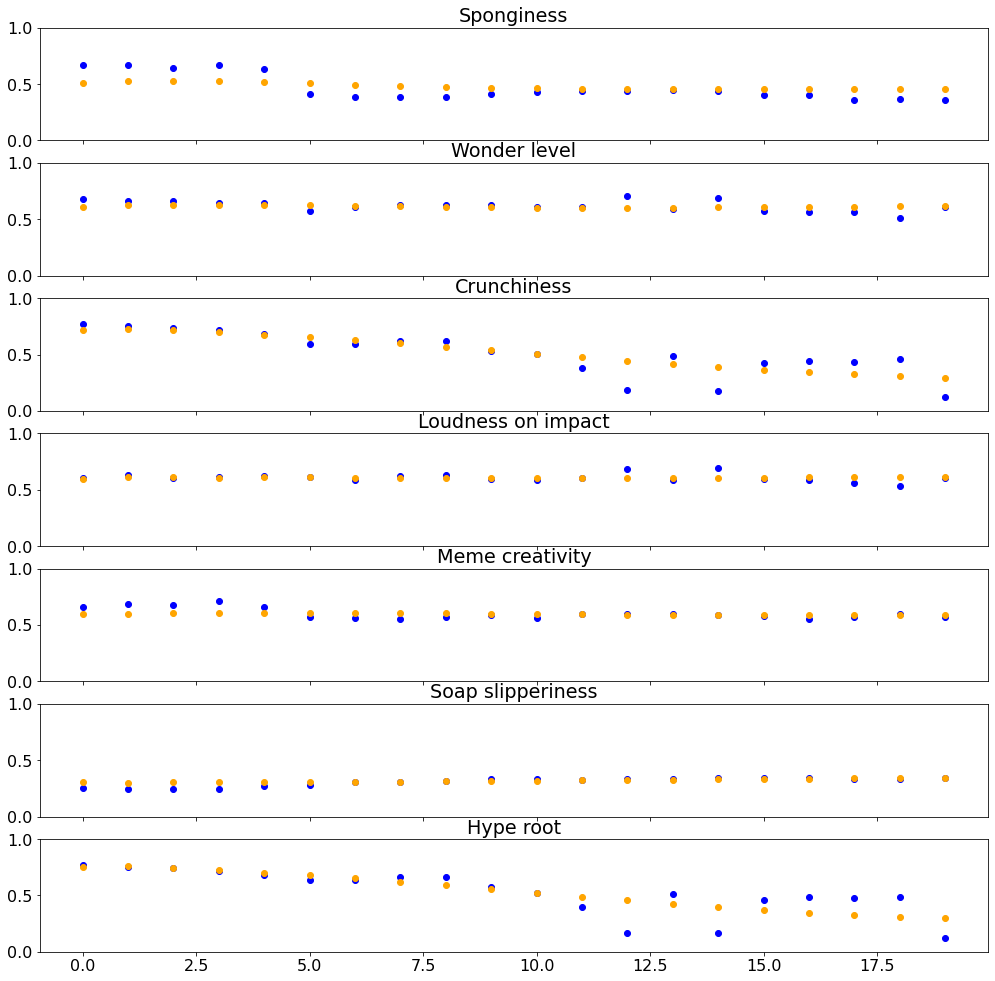

In [165]:
inspect_autoencoder(X_test, predictions, dataset.columns)

In [125]:
models_dir = 'models'
modelname = 'autoencoder_w10_0'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

ae.save(os.path.join(models_dir, modelname))